In [5]:
import sys
root = "/data/luojaa/eukgen/"
sys.path.append(root)

In [6]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [7]:
delete = "Thermoplasmata, Bdellovibrionota, Nitrospirota, Deltaproteobacteria, Thermotogae, Chloroflexota, Deinococcota, Mycoplasmatota, Acidobacteriota, Campylobacterota, Chlamydiia, Spirochaetota, Thermodesulfobacteriota, Campylobacterota".split(", ")

In [119]:
tree_data = pd.read_csv("/data/luojaa/eukgen/microcosm/final_data/tree_data_merged.minHGT.tsv", sep = "\t").set_index("tree_name")
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left")#.drop("Unnamed: 0", axis = 1)
tree_data_tophits = tree_data_mapped.sort_values(["euk_clade_rep", "Score"], ascending = False).drop_duplicates(["euk_clade_rep", "prok_clade_rep"])

/tmp/ipykernel_3467509/1570617376.py:1: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



In [122]:
ec_koginfo = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
ec_koginfo["EC_single"] = ec_koginfo["EC"].apply(lambda x: x.split("|"))
ec_koginfo = ec_koginfo.explode("EC_single")
ec_2kog = ec_koginfo[ec_koginfo.EC_single != "none" ].loc[:,["kogid", "name", "EC_single"]]
ec_2kogs = ec_2kog.groupby("EC_single")["kogid"].apply(lambda x: "|".join(set(x))).reset_index().rename(columns={"EC_single":"EC","kogid":"KOGS"})

ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
tree_data_mapped_2ec = tree_data_tophits[tree_data_tophits.Target.isin(ec_kogs)].reset_index()
tree_data_mapped_2ec["EC"] = tree_data_mapped_2ec.Target.apply(lambda x: ec_2kog_dict[x])
tree_data_mapped_2ec = tree_data_mapped_2ec[~tree_data_mapped_2ec.prok_taxa.isin(delete)]

In [123]:
tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_minHGT_tree_data.tsv", sep = "\t").dropna()
tree_data_dl["EC"] = tree_data_dl.tree_name.apply(lambda x: x.split("_")[0])
dl_annot = pd.read_csv("/data/luojaa/eukgen/microcosm/repseq.microcosms.tmp.tsv", sep = "\t").drop("domain", axis = 1).rename(columns = {"Query":"euk_clade_rep"})

ec_descriptions = pd.read_csv("/data/luojaa/microcosm_metadata/brenda_ec_mappings.tsv", sep = "\t")
ec_info = pd.merge(ec_2kogs, ec_descriptions, on="EC", how="right").drop("comments", axis=1)
tree_data_dl_mapped = pd.merge(tree_data_dl, dl_annot, on=["euk_clade_rep", "EC"], how="left")
tree_data_dl_mapped = pd.merge(tree_data_dl_mapped, ec_info, on="EC", how="left")
tree_data_dl_mapped.fillna("None", inplace=True)
tree_data_dl_mapped = tree_data_dl_mapped.set_index("tree_name")
tree_data_dl_mapped = tree_data_dl_mapped[~tree_data_dl_mapped.prok_taxa.isin(delete)]

/tmp/ipykernel_3467509/2123713028.py:1: DtypeWarning:

Columns (3,4,7,10,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [182]:
trees_dl_cELW = tree_data_dl_mapped[tree_data_dl_mapped["c-ELW"].between(.4,1) & (tree_data_dl_mapped.logL != -1)].reset_index()#.drop("index")
trees_cELW = tree_data_mapped_2ec[(tree_data_mapped_2ec.logL != -1)].reset_index().drop("index", axis = 1)
trees_cELW["EC_KOG"] = trees_cELW.EC + "_" + trees_cELW.Target
ec2cELWsum = {}
for eckog in set(trees_cELW["EC_KOG"]):
    ec2cELWsum[eckog] = len(trees_cELW[trees_cELW.EC_KOG == eckog]["euk_clade_rep"].unique())
trees_cELW["cELW_norm"] = trees_cELW["c-ELW"] / trees_cELW.EC_KOG.apply(lambda x: ec2cELWsum[x])
trees_cELW = trees_cELW[trees_cELW["c-ELW"].between(.4,1)]

# # important: write to output for sankey analysis
trees_cELW.to_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.final.tsv", sep = "\t", index = None)
trees_dl_cELW.to_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.final.tsv", sep = "\t", index = None)

In [183]:
trees_dl_cELW

,tree_name,euk_clade_rep,euk_clade_size,euk_clade_weight,euk_leaf_clade,euk_LCA,euk_scope,euk_scope_len,prok_clade_rep,prok_clade_size,...,p-SH,p-SH_accept,c-ELW,c-ELW_accept,p-AU,p-AU_accept,EC,confidence,KOGS,description
0,1.10.2.2_None,EP00455P022251,288.0,0.975694,False,cellular organisms,Amoebozoa|Haptista|Ochrophyta|Oomycota|Cryptop...,18,WP_041420710_1,3.0,...,1.000,+,0.495,+,0.662,+,1.10.2.2,1.0000,None,quinol-cytochrome-c reductase
1,1.10.3.2_K05909,EP00104P037668,84.0,0.724138,False,Eukaryota,Dinophyceae|Metazoa,2,WP_061579872_1,15.0,...,1.000,+,0.500,+,0.514,+,1.10.3.2,0.9273,K05909|K00421,laccase
2,1.10.3.2_K05909,EP00104P037668,84.0,0.724138,False,Eukaryota,Dinophyceae|Metazoa,2,WP_223291533_1,58.0,...,0.493,+,0.500,+,0.486,+,1.10.3.2,0.9273,K05909|K00421,laccase
3,1.10.3.2_K05909,EP00566P006473,871.0,0.882472,False,Eukaryota,Streptophyta|Ochrophyta|Chlorophyta|Rhodophyta...,9,WP_061579872_1,15.0,...,1.000,+,0.500,+,0.508,+,1.10.3.2,0.9859,K05909|K00421,laccase
4,1.10.3.2_K05909,EP00566P006473,871.0,0.882472,False,Eukaryota,Streptophyta|Ochrophyta|Chlorophyta|Rhodophyta...,9,WP_223291533_1,58.0,...,0.495,+,0.500,+,0.492,+,1.10.3.2,0.9859,K05909|K00421,laccase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,7.6.2.2_K18104,EP01132P016522,8.0,0.21621621621621623,False,Eukaryota,Filasterea|Streptophyta|Ochrophyta|Amoebozoa|M...,5,WP_014856226_1,82.0,...,1.000,+,0.900,+,0.992,+,7.6.2.2,0.5048,K18104|K05659|K05658,ABC-type xenobiotic transporter
3020,7.6.2.2_None,EP00255P008915,219.0,0.46595744680851064,False,Eukaryota,Amoebozoa|Streptophyta|Ochrophyta|Metazoa,4,WP_108877988_1,3.0,...,1.000,+,0.500,+,0.812,+,7.6.2.2,0.7317,K18104|K05659|K05658,ABC-type xenobiotic transporter
3021,7.6.2.2_None,JAHQWZ010000374.1_1,294.0,0.8537414965986394,False,cellular organisms,Amoebozoa|Euglenida|Metazoa|Ochrophyta|Oomycot...,19,WP_108877988_1,3.0,...,0.803,+,0.410,+,0.525,+,7.6.2.2,0.3263,K18104|K05659|K05658,ABC-type xenobiotic transporter
3022,7.6.2.2_None,JAHQWZ010000374.1_1,294.0,0.8537414965986394,False,cellular organisms,Amoebozoa|Euglenida|Metazoa|Ochrophyta|Oomycot...,19,WP_126196162_1,4.0,...,1.000,+,0.405,+,0.563,+,7.6.2.2,0.3263,K18104|K05659|K05658,ABC-type xenobiotic transporter


In [126]:
kog_brite = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
brite_desc = pd.read_csv("/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv", dtype=str, sep = "\t").set_index("brite_id")
brite_desc = brite_desc[~brite_desc.brite_B.isin(["09191", "09192", "09193"])] # unclassified
brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]
brite_c_desc = brite_desc[brite_desc.brite_C != "none"]
brite_c_2desc = brite_c_desc.reset_index().set_index("brite_C")["name"].to_dict()
def get_brite_c_desc(c_ids):
    c_ids_list = c_ids.split("|")
    desc_list = []
    for c_id in c_ids_list:
        try:
            desc = brite_c_2desc[c_id]
            desc_list += [desc]
        except KeyError:
            desc = "Unclassified"
            desc_list += [desc]
    return "|".join(desc_list)
kog_brite["description_brite_c"] = kog_brite["brite_C"].apply(lambda x: get_brite_c_desc(x))

In [127]:
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg_stats/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")].reset_index()
pathway_data["pathway"] = pathway_data.CATEGORY_NAME + " | " + pathway_data.CATEGORY_ID

In [128]:
def remove_hgt(df):
    return df[(df['c-ELW'].between(0.4, 1))
              & ~((df['c-ELW'].between(0.99, 1) & (df.prok_taxa != 'Asgard')))
              & ((df['deltaL'] != -1) | (df.prok_taxa == 'Asgard'))
              & (df.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
              & (pd.to_numeric(df.euk_scope_len) > 5)]

In [129]:
# generate summary plots
cELW_dl_breakdowns, cELW_breakdowns = {}, {}
brite2desc = brite_b_desc[brite_b_desc.brite_A == "09100"].drop(["brite_A", "brite_B"], axis = 1).to_dict()["name"]

for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_filtered = trees_cELW[trees_cELW.Target.isin(kogs)].reset_index()
    trees_cELW_breakdown = remove_hgt(trees_filtered)
    cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())
    cELW_breakdowns[brite2desc[briteid]] = cELW_freq.sort_values()
    print(len(trees_cELW_breakdown))
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_dl_filtered = trees_dl_cELW[trees_dl_cELW.KOGS.str.contains("|".join(kogs_dl))].reset_index()
    trees_dl_cELW_breakdown = remove_hgt(trees_dl_filtered)
    cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())
    cELW_dl_breakdowns[brite2desc[briteid]] = cELW_dl_freq.sort_values()
    print(len(trees_dl_cELW_breakdown))

09101 Carbohydrate metabolism
649
09102 Energy metabolism
243
09103 Lipid metabolism
500
09104 Nucleotide metabolism
213
09105 Amino acid metabolism
607
09106 Metabolism of other amino acids
269
09107 Glycan biosynthesis and metabolism
291
09108 Metabolism of cofactors and vitamins
512
09109 Metabolism of terpenoids and polyketides
114
09110 Biosynthesis of other secondary metabolites
197
09111 Xenobiotics biodegradation and metabolism
208
09112 Not included in regular maps
0
09101 Carbohydrate metabolism
290
09102 Energy metabolism
149
09103 Lipid metabolism
135
09104 Nucleotide metabolism
112
09105 Amino acid metabolism
287
09106 Metabolism of other amino acids
135
09107 Glycan biosynthesis and metabolism
45
09108 Metabolism of cofactors and vitamins
210
09109 Metabolism of terpenoids and polyketides
43
09110 Biosynthesis of other secondary metabolites
67
09111 Xenobiotics biodegradation and metabolism
79
09112 Not included in regular maps
0


In [130]:
# # all metabolic kogs
kogs_metabolic = []
for bid in list(brite2desc.keys()):
    kogs_metabolic += list(kog_brite[(kog_brite.brite_B.str.contains(bid))].kogid.unique())
kogs_metabolic = set(kogs_metabolic)

trees_filtered = trees_cELW[trees_cELW.Target.isin(kogs_metabolic)].reset_index()
trees_cELW_breakdown = remove_hgt(trees_filtered)
cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())

trees_dl_filtered = trees_dl_cELW[trees_dl_cELW.KOGS.str.contains("|".join(kogs_metabolic))].reset_index()
trees_dl_cELW_breakdown = remove_hgt(trees_dl_filtered)
cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())

Text(0.5, 1.0, 'All metabolic KOGs')

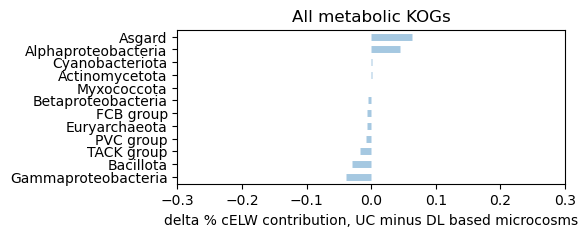

In [131]:
cELW_delta_df = (cELW_freq - cELW_dl_freq).reset_index()
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)
plt.figure(figsize=(5,2))
plt.hlines(y=cELW_delta_df.sort_values(0).prok_taxa, xmin=0, xmax=cELW_delta_df[0].sort_values(), 
           alpha=0.4, linewidth=5) 
plt.xlim(-.3,.3)
plt.xlabel("delta % cELW contribution, UC minus DL based microcosms")
plt.title(f"All metabolic KOGs")

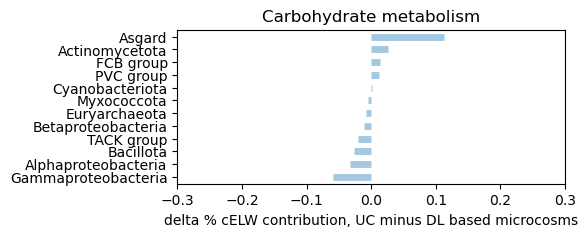

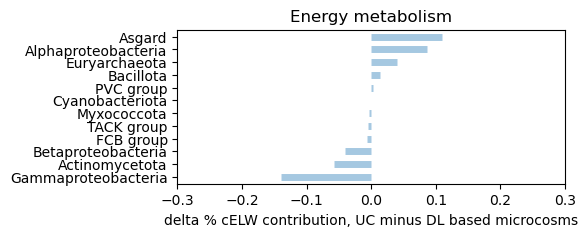

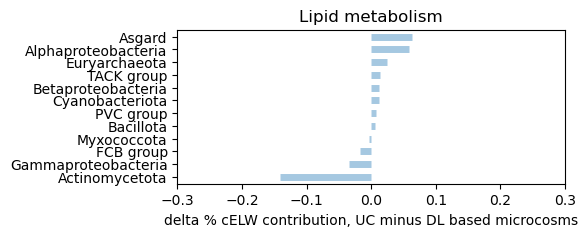

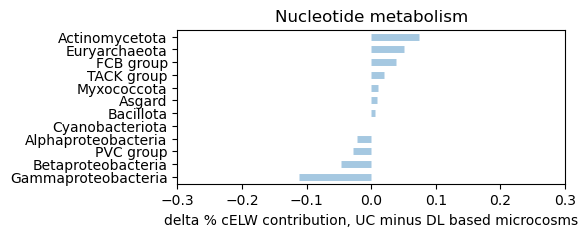

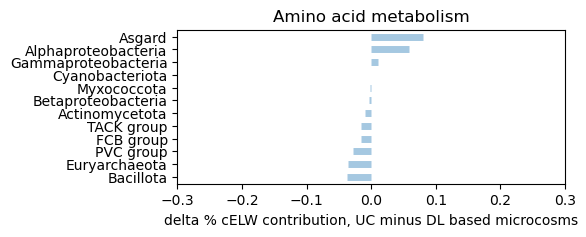

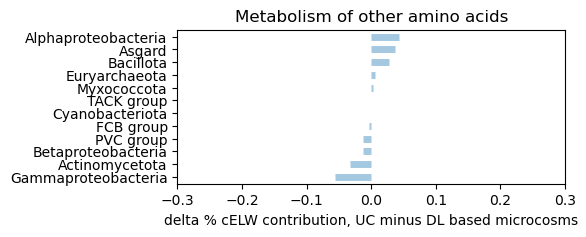

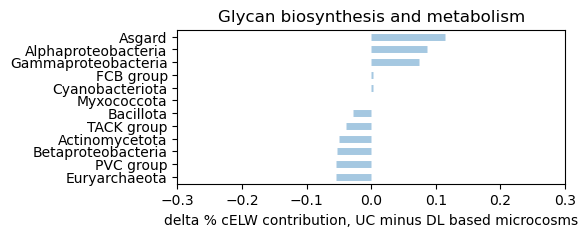

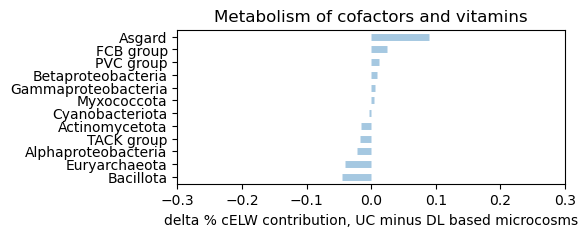

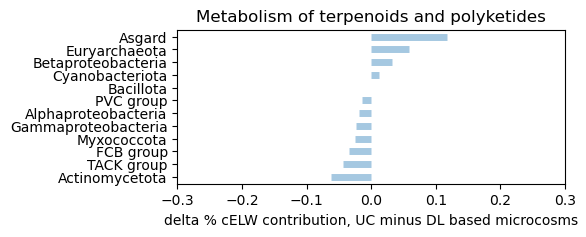

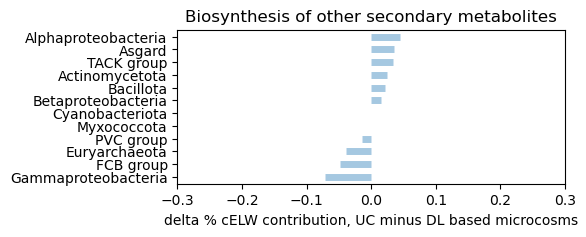

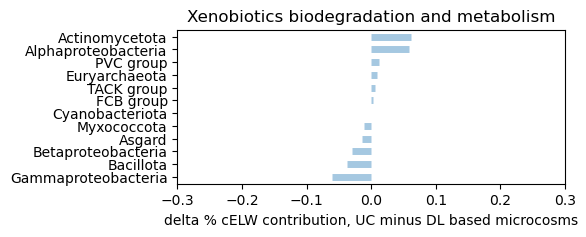

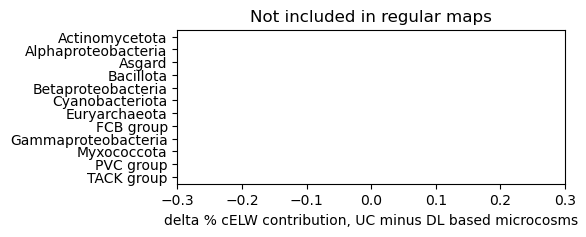

In [132]:
# breakdown
cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_delta_df = cELW_df - cELW_dl_df
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)
for colname in cELW_delta_df.columns:
    plt.figure(figsize=(5,2))
    plt.hlines(y=cELW_delta_df.sort_values(colname).index, xmin=0, xmax=cELW_delta_df[colname].sort_values(), 
               alpha=0.4, linewidth=5) 
    plt.xlim(-.3,.3)
    plt.xlabel("delta % cELW contribution, UC minus DL based microcosms")
    plt.title(f"{colname}")

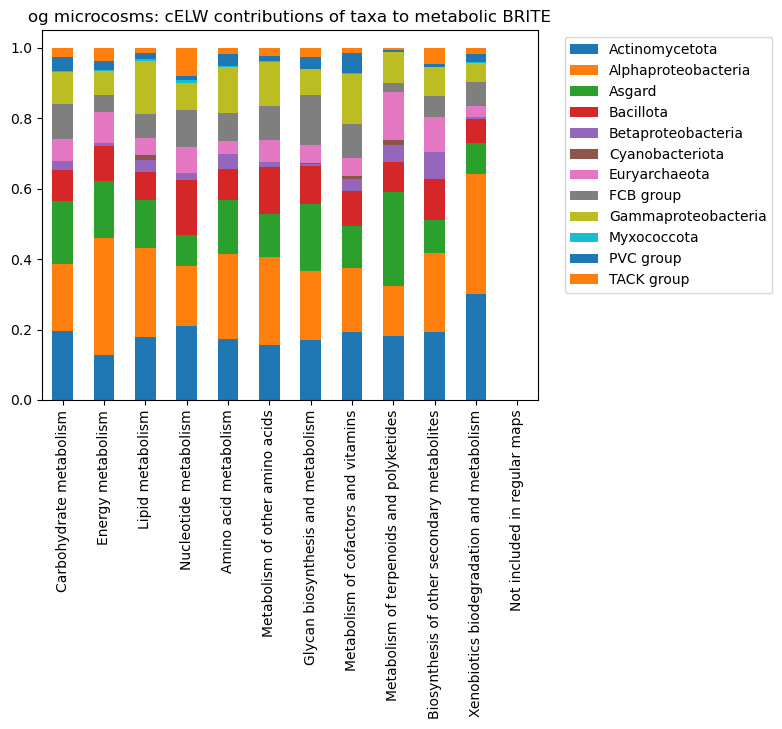

In [133]:
cELW_df.T.plot(kind='bar', stacked=True,
        title='og microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", )

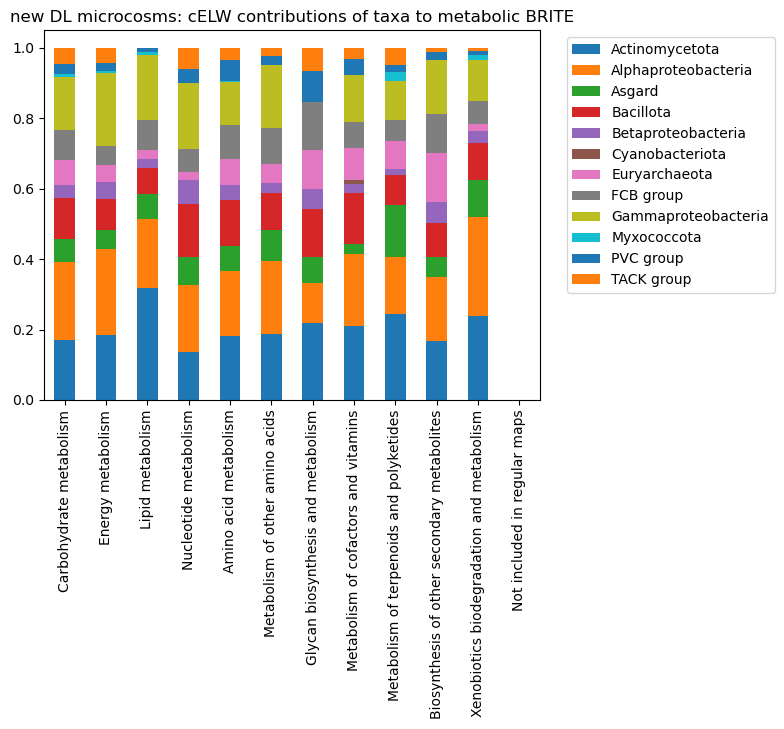

In [37]:
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_dl_df.T.plot(kind='bar', stacked=True,
        title='new DL microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

# Sankey

In [135]:
trees_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.final.tsv", sep = "\t")
trees_dl_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.final.tsv", sep = "\t")

In [136]:
# map the new taxa onto the old microcosm df
old2new_taxa = trees_dl_cELW.groupby("tree_name")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
def map_old2new(ec_kog):
    try:
        return old2new_taxa[ec_kog]
    except KeyError:
        return "None"
        # try:
        #     ec_kog = ec_kog.split("_")[0] + "_None"
        #     return old2new_taxa[ec_kog]
        # except KeyError:
        #     return "None"
        
trees_cELW["prok_taxa_new"] = trees_cELW.EC_KOG.apply(lambda x: map_old2new(x))

In [139]:
def reweighted_cELWs(df_uc):
    g = df_uc.groupby("prok_taxa_new")["cELW_norm"].sum().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["cELW_weighted"] = g["cELW_norm"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    # round, to clean up outliers with minimal contributions
    reweighted = h.groupby("taxa")["cELW_weighted"].sum().round().sort_values(ascending = False)
    return reweighted#[reweighted.index != "None"]
def reweighted_vc(s):
    g = s.value_counts().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["count_weighted"] = g["count"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted_vc = h.groupby("taxa")["count_weighted"].sum().round().sort_values(ascending = False)
    return reweighted_vc#[reweighted_vc.index != "None"]

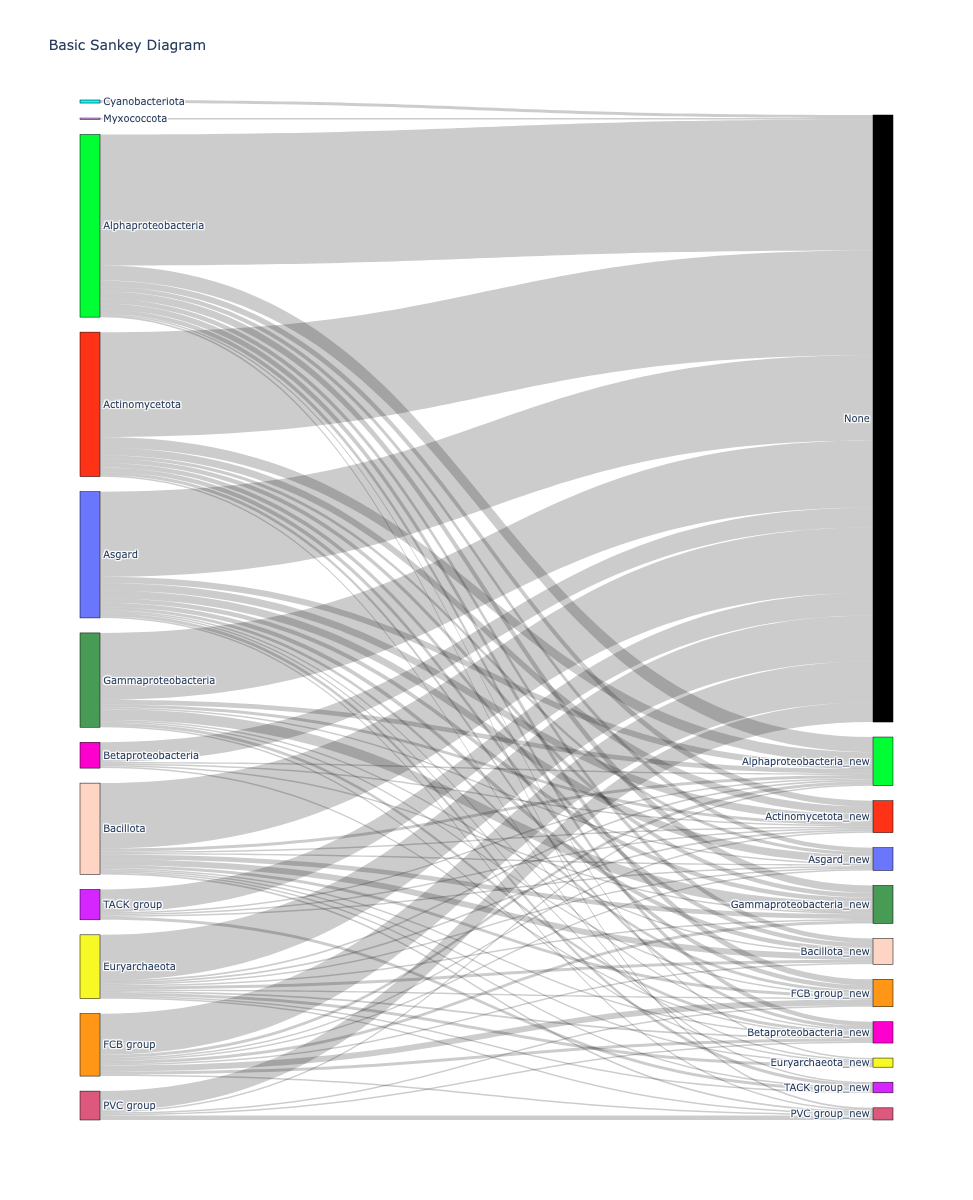

In [140]:
trees_cELW_plot = trees_cELW
trees_cELW_plot = remove_hgt(trees_cELW)

trees_cELW_dl_plot = trees_dl_cELW
trees_cELW_dl_plot = remove_hgt(trees_dl_cELW)

# get all possible labels
label = list(pd.concat([trees_cELW_dl_plot.prok_taxa, trees_cELW_plot.prok_taxa]).sort_values().unique())
# uc then dl labels
label_all = label + [i + "_new" for i in label] + ["None"]
# distribution of where uc cELW weight goes
cELWs = [reweighted_cELWs(trees_cELW_plot[trees_cELW_plot.prok_taxa == taxa]) for taxa in label]
#label_map = {v:k for k, v in dict(enumerate(label)).items()}
label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}

source, target, value, j = [], [], [], 0
for i in cELWs:
    target += [label_map[taxa] + 12 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig1 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = (px.colors.qualitative.Light24)[:12]*2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig1.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig1.show()


In [141]:
# reverse mapping, old onto new
new2old_taxa = trees_cELW.groupby("EC_KOG")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
new_tids = set(trees_dl_cELW.tree_name)
new_none2old_taxa = {}
for old_taxa in new2old_taxa.keys():
    if old_taxa not in new_tids:
        ec_none = old_taxa.split("_")[0] + "_None"
        new_none2old_taxa[ec_none] = new2old_taxa[old_taxa]
def map_new2old(ec_kog):
    try:
        return new2old_taxa[ec_kog]
    except KeyError:
        try:
            return new_none2old_taxa[ec_kog]
        except KeyError:
            return "None"
trees_dl_cELW["prok_taxa_old"] = trees_dl_cELW.tree_name.apply(lambda x: map_new2old(x))

In [142]:
kog_2briteC = kog_brite.rename(columns={"kogid":"Target"}).loc[:,["Target", "brite_C", "description_brite_c"]]

In [143]:
# filter out microcosms that have an EC but not an EC-KOG match (so mapping reads "None") between UC/DL
dl_ECs = set(trees_dl_cELW.EC)
uc_ECs = set(trees_cELW.EC)
uc_matched_ECs = set(trees_cELW[trees_cELW["prok_taxa_new"] == "None"].EC).intersection(dl_ECs)
dl_matched_ECs = set(trees_dl_cELW[trees_dl_cELW["prok_taxa_old"] == "None"].EC).intersection(uc_ECs)


In [159]:
taxas = ["Global"] + label
cELWs, brite_vcs, map_vcs = [], [], []
for taxa in taxas:
    trees_cELW_filt = trees_cELW[trees_cELW.prok_taxa == taxa].sort_values(["cELW_norm", "c-ELW"], ascending = False)
    if taxa == "Global":
        trees_cELW_filt = trees_cELW.sort_values(["cELW_norm", "c-ELW"], ascending = False)
        s_sametax = []
        new_tax = list(trees_cELW_filt.prok_taxa_new)
        uc_tax = list(trees_cELW_filt.prok_taxa)
        for i in range(len(trees_cELW_filt)):
            s_sametax.append(uc_tax[i] not in new_tax[i])
        trees_cELW_filt = trees_cELW_filt[s_sametax]
    g = pd.merge(trees_cELW_filt, kog_2briteC, on = "Target", how = "left").fillna("None")
    h = g[~g.prok_taxa_new.str.contains(taxa) & ~(g.EC.isin(uc_matched_ECs))].sort_values("c-ELW")
    h = pd.merge(h, pathway_data.rename(columns={"KOGID":"Target"}), on = "Target", how = "left").fillna("no_pathway")
    i = remove_hgt(h).set_index("cELW_norm")
    cELW_dist = i.description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["cELW_norm"].sum().sort_values(ascending=False).iloc[:50]
    brite_vc = i.description_brite_c.str.split("|").explode().reset_index().description_brite_c.value_counts()
    #cELWs.append(cELW_dist)
    brite_vcs.append(brite_vc)
    map_vc = i.reset_index().pathway.value_counts()
    map_vcs.append(map_vc)
    

In [206]:
t = trees_cELW_plot.EC_KOG.value_counts().reset_index()
s = t[t["count"] == 1]
s

,EC_KOG,count
986,2.7.8.8_K17103,1
987,1.8.4.10_K00390,1
988,2.4.1.47_K04628,1
989,5.1.99.1_K05606,1
990,7.2.2.1_K02111,1
...,...,...
1719,1.8.1.4_K00382,1
1720,1.11.1.24_K23856,1
1721,1.11.1.24_K11187,1
1722,1.1.1.239_K13368,1


In [207]:
trees_cELW_plot[(trees_cELW_plot.EC_KOG.isin(s.EC_KOG)) & (trees_cELW_plot.prok_taxa_new != "None")]

,tree_name,Unnamed: 0,euk_clade_rep,euk_clade_size,euk_clade_weight,euk_leaf_clade,euk_LCA,euk_scope,euk_scope_len,prok_clade_rep,...,p-AU,p-AU_accept,Target,Score,Description,Pairwise_cov,EC,EC_KOG,cELW_norm,prok_taxa_new
142,EP00367P003609,12,XP_008903210.1,63,0.818182,False,Eukaryota,Ochrophyta|Bigyra|Oomycota|Eukaryota incertae ...,10,WP_002990921_1,...,0.825,+,K11754,1024.7,dihydrofolate synthase / folylpolyglutamate sy...,0.932280,6.3.2.17,6.3.2.17_K11754,0.105500,"Bacillota,Actinomycetota"
153,EP00043P003097,1,XP_008667321.1,10,0.714286,False,Eukaryota,Choanoflagellata|Metazoa|Ciliophora|Colpodelli...,7,WP_006559945_1,...,0.964,+,K12235,760.1,serine racemase [EC:5.1.1.18],0.869919,5.1.1.18,5.1.1.18_K12235,0.452500,"Asgard,Alphaproteobacteria"
271,EP00850P010165,1,WP_215584454_1,37,0.945946,False,cellular organisms,Ascomycota|Streptophyta|Chlorophyta|Amoebozoa|...,7,WP_012944756_1,...,0.956,+,K17285,285.1,methanethiol oxidase [EC:1.8.3.4],0.875546,1.8.3.4,1.8.3.4_K17285,0.166400,TACK group
274,EP01116P008921,20,WP_211422049_1,220,0.934241,False,cellular organisms,Ciliophora|Ascomycota|Fungi incertae sedis|Eug...,19,WP_182442465_1,...,0.862,+,K00457,1026.3,4-hydroxyphenylpyruvate dioxygenase [EC:1.13.1...,0.960938,1.13.11.27,1.13.11.27_K00457,0.058444,"Actinomycetota,FCB group"
280,KAA6393537.1,0,WP_194793199_1,32,0.906250,False,cellular organisms,Metamonada|Rhizaria|Filasterea|Dinophyceae|Och...,14,JAHQXB010000045.1_1,...,0.613,+,K01911,257.2,o-succinylbenzoate---CoA ligase [EC:6.2.1.26],0.513274,6.2.1.26,6.2.1.26_K01911,0.190000,Actinomycetota
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9029,EP00820P017119,8,EP00004P012315,46,0.920000,False,Eukaryota,Euglenida|Bigyra|Choanoflagellata|Ochrophyta|D...,10,YP_002517418_1,...,0.633,+,K00626,346.4,acetyl-CoA C-acetyltransferase [EC:2.3.1.9],0.698113,2.3.1.9,2.3.1.9_K00626,0.139667,"Myxococcota,Bacillota,Alphaproteobacteria"
9091,EP00586P008382,7,CEM34435.1,18,0.782609,False,Eukaryota,Rhodophyta|Colpodellida|Bigyra|Chlorophyta|Din...,7,WP_136190956_1,...,0.962,+,K01669,937.0,deoxyribodipyrimidine photo-lyase [EC:4.1.99.3],0.852823,4.1.99.3,4.1.99.3_K01669,0.123286,FCB group
9104,EP00051P001236,11,CBN80098.1,368,0.972826,False,cellular organisms,Cryptophyceae|Rhizaria|Ascomycota|Fungi incert...,20,WP_220161432_1,...,0.918,+,K01736,1284.4,chorismate synthase [EC:4.2.3.5],0.942559,4.2.3.5,4.2.3.5_K01736,0.374500,"PVC group,Alphaproteobacteria"
9107,EP00654P002639,1,CBJ30062.1,157,0.773399,False,Eukaryota,Amoebozoa|Ochrophyta|Oomycota|Bigyra|Rhodophyt...,15,JAHQWY010000142.1_7,...,0.970,+,K00938,973.8,phosphomevalonate kinase [EC:2.7.4.2],0.968750,2.7.4.2,2.7.4.2_K00938,0.322000,TACK group


In [160]:
taxas = ["Global"] + label
cELWs_dl, brite_vcs_dl, map_vcs_dl = [], [], []
for taxa in taxas:
    trees_cELW_dl_filt = trees_dl_cELW[trees_dl_cELW.prok_taxa == taxa].sort_values(["c-ELW"], ascending = False)
    if taxa == "Global":
        trees_cELW_dl_filt = trees_dl_cELW.sort_values(["c-ELW"], ascending = False)
        s_sametax = []
        new_tax = list(trees_cELW_dl_filt.prok_taxa_old)
        uc_tax = list(trees_cELW_dl_filt.prok_taxa)
        for i in range(len(trees_cELW_dl_filt)):
            s_sametax.append(uc_tax[i] not in new_tax[i])
        trees_cELW_dl_filt = trees_cELW_dl_filt[s_sametax]
    trees_cELW_dl_filt["KOGID"] = trees_cELW_dl_filt.tree_name.apply(lambda x: x.split("_")[1])
    # drop nulls, which are EC_None
    m = pd.merge(trees_cELW_dl_filt.rename(columns={"KOGID":"Target"}), kog_2briteC, on = "Target", how = "left").dropna()
    n = m[~m.prok_taxa_old.str.contains(taxa) & ~(m.EC.isin(dl_matched_ECs))].sort_values("c-ELW")
    n = pd.merge(n, pathway_data.rename(columns={"KOGID":"Target"}), on = "Target", how = "left").fillna("no_pathway")
    o = remove_hgt(n).set_index("c-ELW")
    cELW_dist = o.description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["c-ELW"].sum().sort_values(ascending=False).iloc[:50]
    #cELWs_dl.append(cELW_dist)
    brite_vc = o.description_brite_c.str.split("|").explode().reset_index().description_brite_c.value_counts()
    brite_vcs_dl.append(brite_vc)
    map_vc = o.reset_index().pathway.value_counts()
    map_vcs_dl.append(map_vc)
    

In [161]:
cELW_breakdowns_UCnotDL = pd.concat(brite_vcs,axis = 1).fillna(0)
cELW_breakdowns_UCnotDL.columns = taxas
cELW_breakdowns_UCnotDL.to_csv("briteC_comparison.UCnotDL.tsv", sep = "\t")


In [162]:
cELW_breakdowns_DLnotUC = pd.concat(brite_vcs_dl,axis = 1).fillna(0)
cELW_breakdowns_DLnotUC.columns = taxas
cELW_breakdowns_DLnotUC.to_csv("briteC_comparison.DLnotUC.tsv", sep = "\t")


In [163]:
cELW_breakdowns_UCnotDL = pd.concat(map_vcs,axis = 1).fillna(0)
cELW_breakdowns_UCnotDL.columns = taxas
cELW_breakdowns_UCnotDL.to_csv("map_comparison.UCnotDL.tsv", sep = "\t")


In [164]:
cELW_breakdowns_DLnotUC = pd.concat(map_vcs_dl,axis = 1).fillna(0)
cELW_breakdowns_DLnotUC.columns = taxas
cELW_breakdowns_DLnotUC.to_csv("map_comparison.DLnotUC.tsv", sep = "\t")


In [156]:
def reweighted_cELWs_dl(df_uc):
    g = df_uc.groupby("prok_taxa_old")["c-ELW"].sum().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["cELW_weighted"] = g["c-ELW"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted = h.groupby("taxa")["cELW_weighted"].sum().round().sort_values(ascending = False)
    return reweighted[reweighted.index != "None"]

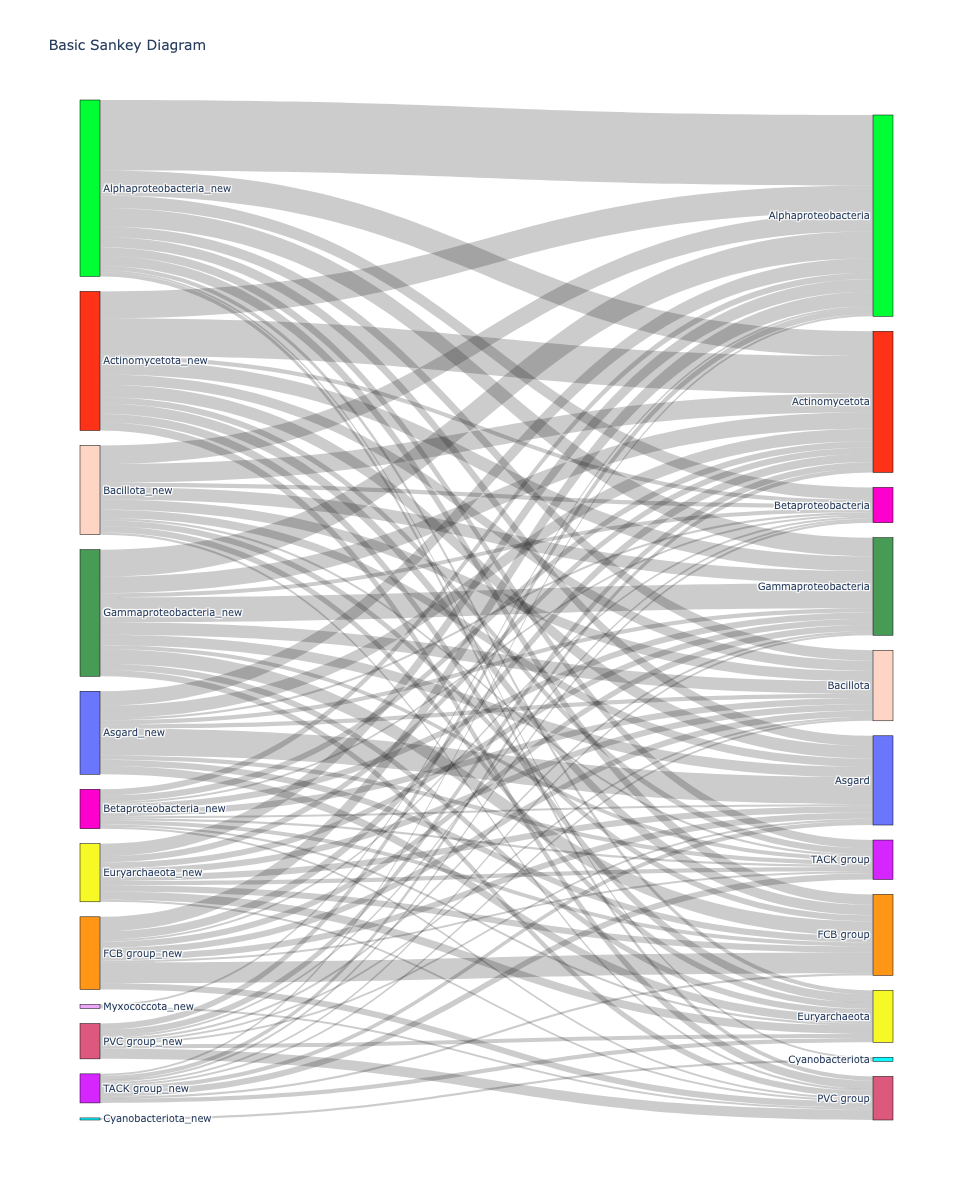

In [157]:
trees_cELW_dl_plot = trees_dl_cELW
trees_cELW_dl_plot = remove_hgt(trees_dl_cELW)

# get all possible labels
label = list(pd.concat([trees_cELW_dl_plot.prok_taxa, trees_cELW_plot.prok_taxa]).sort_values().unique())
# uc then dl labels
label_all = [i + "_new" for i in label] + label #+ ["None"]
# distribution of where dl cELW weight goes
cELWs = [reweighted_cELWs_dl(trees_cELW_dl_plot[trees_cELW_dl_plot.prok_taxa == taxa]) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label)).items()}
#label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}
source, target, value, j = [], [], [], 0
for i in cELWs:
    target += [label_map[taxa] + 12 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig1 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = (px.colors.qualitative.Light24)[:12]*2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig1.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig1.show()


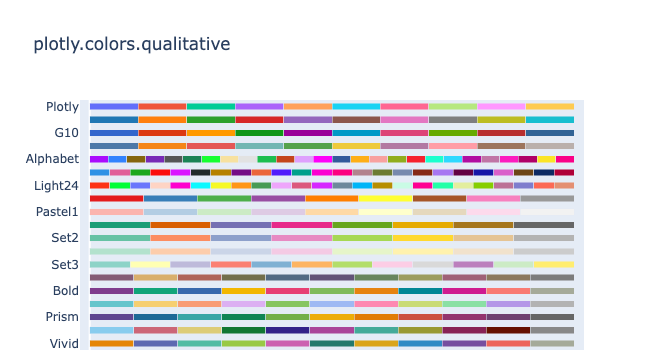

In [268]:
fig = px.colors.qualitative.swatches()
fig.show()

# microcosms